In [6]:
import logging
from datetime import datetime, timedelta
import pandas as pd

from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc
from src.data.get_data import YahooFinanceAPI as yfapi
from env import Env


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = (f'{Env.PROJECT_ROOT}/data/03_processed/daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
    },
    'data': {
        'test_size': 0.05,
    },

    'model_name': 'MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04',
}

In [7]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

df_test_X = df_test.drop(columns=['Adj Close'])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test['Adj Close']

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model_name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

2023-10-14 04:23:35 - src.data.get_data - INFO - Loaded "../P7-Trading-Bot/data/03_processed/daily_full". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"
2023-10-14 04:23:35 - __main__ - INFO - df.shape: (5994, 3)
2023-10-14 04:23:35 - __main__ - INFO - df.shape: (5994, 3)
2023-10-14 04:23:35 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')


2023-10-14 04:23:35 - __main__ - INFO - df.columns: Index(['Adj Close', 'Adj Close - 1', 'Volume - 1'], dtype='object')
2023-10-14 04:23:35 - __main__ - INFO - df_train.shape: (5695, 3), df_test.shape: (299, 3)
2023-10-14 04:23:35 - __main__ - INFO - df_train.shape: (5695, 3), df_test.shape: (299, 3)
2023-10-14 04:23:35 - __main__ - INFO - Model loaded from: /workspaces/P7-Trading-Bot/models_trained/keep/MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.keras
2023-10-14 04:23:35 - __main__ - INFO - Model loaded from: /workspaces/P7-Trading-Bot/models_trained/keep/MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.keras
2023-10-14 04:23:36 - __main__ - INFO - Scalers loaded: /workspaces/P7-Trading-Bot/models_trained/keep/MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04_scalers.pkl
2023-10-14 04:23:36 - __main__ - INFO - Scalers loaded: /workspaces/P7-Trading-Bot/models_trained/keep/MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04_scalers.pkl


280/280 [==============================] - 3s 6ms/step


2023-10-14 04:23:38.733835: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6551924521207605886
2023-10-14 04:23:39 - src.common.plots - INFO - Plot "Predictions MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04-MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.png" saved to "/workspaces/P7-Trading-Bot/figures/Predictions MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04-MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04.png"


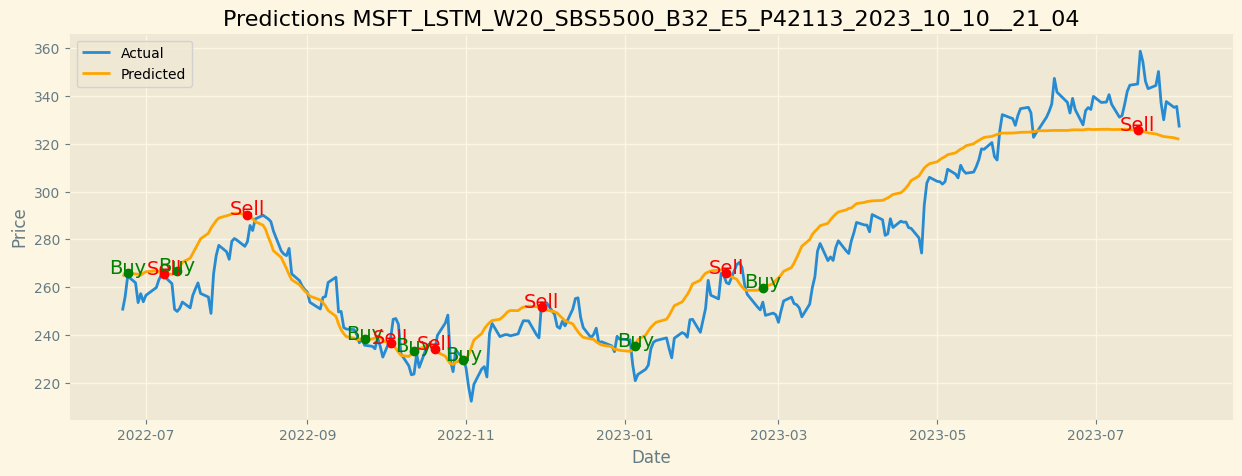

In [8]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)

df_test_plot_y = TFModelService.prep_test_df_shape(df_test_y, window_size)

V.plot_series(  x=df_test_plot_y.index,  # as dates
                y=(df_test_plot_y, results),
                model_name=model._name,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='Price',
                legend=['Actual', 'Predicted'],
                show=True,)

In [9]:
# -----------------------Calculate Errors----------------------------------
naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_plot_y.index] # Getting same days as results
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_plot_y, results, naive_forecast)
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-10-14 04:23:39 - src.models_service.errors - INFO - Test RMSE: $ 12.029
2023-10-14 04:23:39 - src.models_service.errors - INFO - Test MAE : $ 9.886
2023-10-14 04:23:39 - src.models_service.errors - INFO - Test MAPE:   0.037
2023-10-14 04:23:39 - src.models_service.errors - INFO - Test MASE:   2.445


2023-10-14 04:23:39 - src.models_service.errors - INFO - Errors saved to for MSFT_LSTM_W20_SBS5500_B32_E5_P42113_2023_10_10__21_04 model to "logs/models_table.csv" file.


/workspaces/P7-Trading-Bot/models_trained
